In [98]:
print("Python běží!")

Python běží!


In [99]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [100]:
import my_libs as ml
from my_libs.fft import *
from my_libs.tools import *
from my_libs.colors import *
from my_libs.img.functional import *
from my_libs.img.processing import *
from my_libs.img.morphology import *

In [101]:
ml.tools.printf("Hello world!")

Hello world!

# Cvičení 6
1) Načtěte obrázek `pvi_cv06_mince.jpg`. Obraz převeďte do složky Hue. Na 
základě  histogramu  stanovte  práh  a  obraz  segmentujte.  V  jednom  okně 
zobrazte RGB a Hue obraz, histogram a výsledný segmentovaný obraz. 
 
2)  Na  výsledný  binární  obraz  aplikujte  algoritmus  rozvodí  (watershed). 
Nalezenou  hranici  z  rozvodí  zvětšete  pomocí  dilatace  se  strukturním 
elementem 3x3 a odstraňte z původního segmentovaného obrazu, aby došlo 
k oddělení objektů.  
 
3) Artefakty z oddělení objektů odsraňte při využítí algoritmu barvení oblastí. 
Např.: všechny objekty, které mají méně než 1000 obrazových bodů budou 
odstraněny. 
 
4)  Z  binárního  obrazu  vytvořte  granulometrické  spektrum.  Spektrum 
analyzujte  (např.  od  objektů  velikosti  40x40  obrazových  bodů).  Všechny 
poměry menší než 0,9 zanedbejte. Zaokrouhlení poměru - bez desetiné části.  
 
5)  Výstupem bude velikost objektu a počet objektů. 
 
help:  
- https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html 

In [102]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

In [103]:
DEBUG = True

img_name = "pvi_cv06_mince.jpg"

1) Načtěte obrázek `pvi_cv06_mince.jpg`. Obraz převeďte do složky Hue. Na 
základě  histogramu  stanovte  práh  a  obraz  segmentujte.  V  jednom  okně 
zobrazte RGB a Hue obraz, histogram a výsledný segmentovaný obraz. 

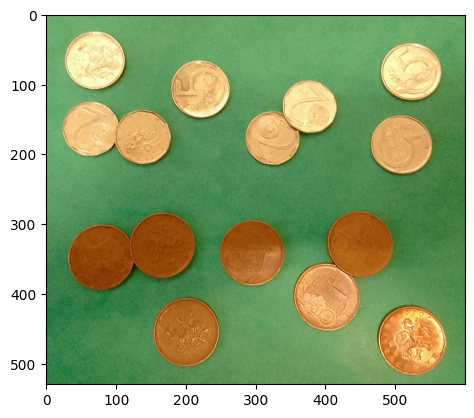

In [104]:
# Read the image and convert it to grayscale
img = cv2.imread(img_name)
assert img is not None, "File: " + Blue + img_name + NC + " could not be read, check with os.path.exists()"
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [105]:
# Grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# HSV
H, S, V = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
img_H = H

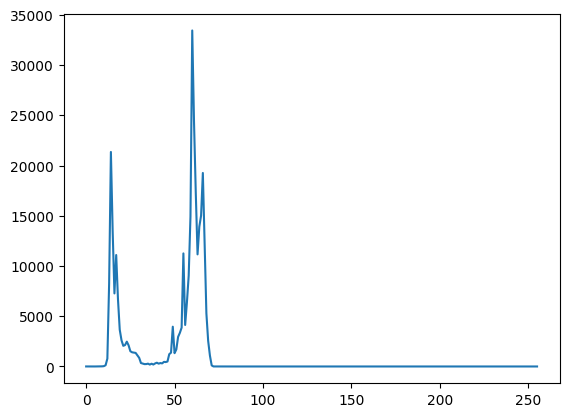

In [106]:
# histogram
hist = histogram(img_H)
plt.plot(hist)

(73, 1)


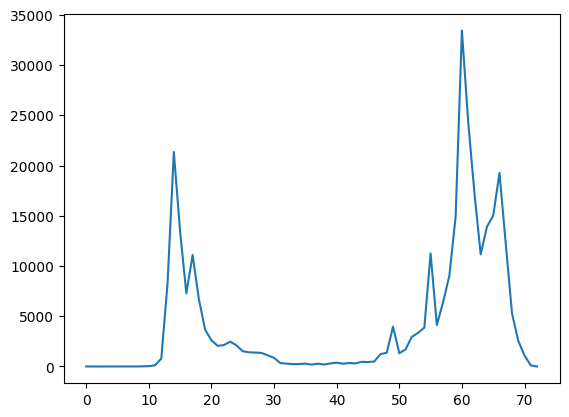

In [107]:
# hist crop from first not zero value to last not zero value

def crop_hist(hist):
    start = 0
    end = len(hist)
    for i in range(len(hist)):
        if hist[i] > 0:
            start = i
            break
    for i in range(len(hist)-1, 0, -1):
        if hist[i] > 0:
            end = i
            break
    return hist[start:end]

hist_crop = crop_hist(hist)
print(hist_crop.shape)
plt.plot(hist_crop)

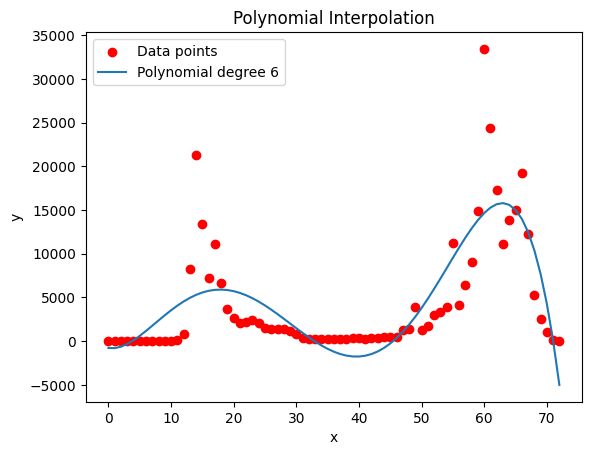

[ 122.68397765   79.61451825  243.83084298  373.1896696   470.80692396
  539.68956321  582.73535428  602.73265249  602.36018     584.18680439
  550.67131713  504.16221214  446.89746433  381.00430809  308.49901581
  231.28667645  151.16097402   69.80396613   11.21413749   90.43519648
  166.51336131  238.21529475  304.42039336  364.12100897  416.42267013
  460.5443036   495.81845583  521.69151444  537.72392966  543.59043587
  539.08027299  524.09740804  498.66075656  462.9044041   417.07782769
  361.54611736  296.79019752  223.40704854  142.10992817   53.728593
   40.79048002  140.38387214  243.8710013   349.9539007   457.21699727
  564.12689027  669.03212973  770.16299502  865.63127339  953.43003846
 1031.43342876 1097.39642625 1148.95463486 1183.62405898 1198.80088204
 1191.76124498 1159.6610248  1099.53561309 1008.29969454  882.74702547
  719.55021236  515.26049038  266.30750189   31.00092501  380.47899797
  786.06318186 1251.81242023 1781.90835683 2380.65555703 3052.48172932
 3801.93

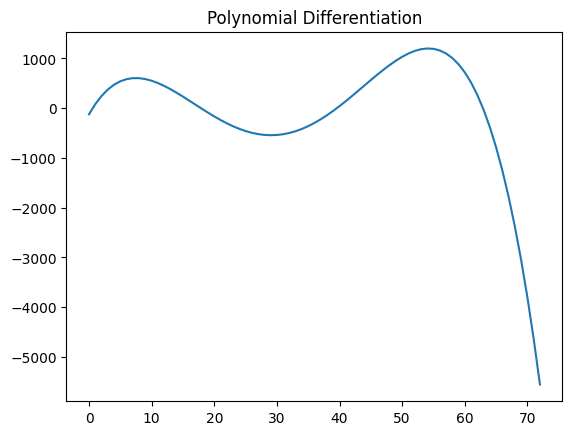

[np.int64(18), np.int64(40), np.int64(63)]


In [108]:
# interpolace histogramu polynomialni funkcí
# prolozeni polynomem 2. stupne

# Stupeň polynomu
degree = 6

data = hist_crop
x = np.arange(len(data))
y = data

# Nalezení koeficientů polynomu
coefficients = np.polyfit(x, y, degree)

# Vyhodnocení polynomu na daných hodnotách x
polynomial = np.polyval(coefficients, x)

# Vykreslení původních datových bodů a interpolovaného polynomu
plt.scatter(x, y, color='red', label='Data points')
plt.plot(x, polynomial, label=f'Polynomial degree {degree}')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Interpolation')
plt.show()

# Derivace polynomu
diff_coefficients = np.polyder(coefficients.ravel())
diff_polynomial = np.polyval(diff_coefficients, x)
print(abs(diff_polynomial))
def find_min(x, d_polynomial):
    mins = []
    T = 50
    for i in range(len(d_polynomial)):
        if abs(d_polynomial[i]) <= T:
            mins.append(x[i])
    return mins

plt.plot(x, diff_polynomial, label=f'Polynomial degree {degree}')
plt.title("Polynomial Differentiation")
plt.show()
mins = find_min(x, diff_polynomial)
print(mins)

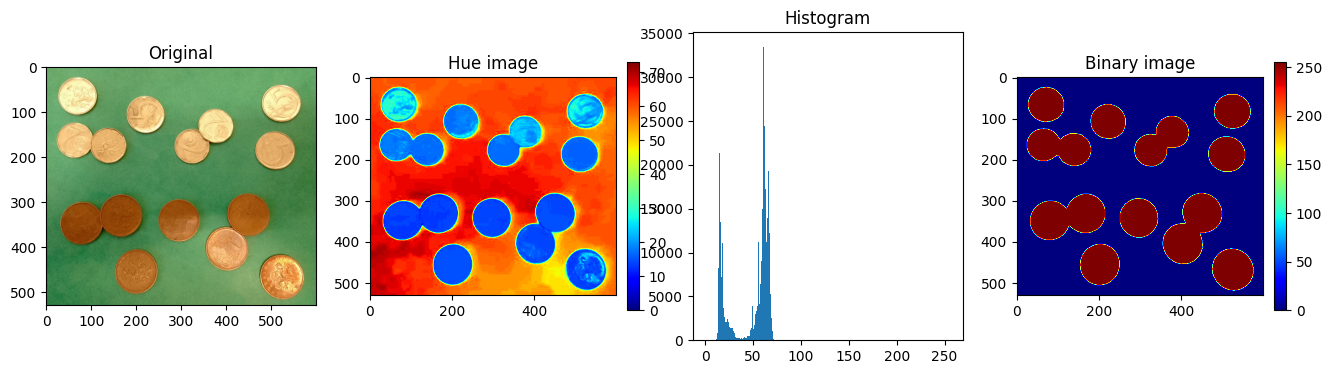

In [109]:
def plot_segmentation(img, img_H, title:str="Gray image", T:int = 125, invert:bool = False):
    """
    Plot:
    - Original, 
    - Hue, 
    - histogram
    - binary image with segmentation
    """
    plot_imgs(
        imgs=[img, img_H, img_H, segmentate(img_H, T, 255, invert=invert)], 
        titles=["Original", title, "Histogram", "Binary image"], 
        rows=1, 
        cmaps=[None, 'jet', None, 'jet'], 
        cbars=[None, True, None, True],
        hist=[None, None, True, None],
        figsize=(16, 4))

T = 40
plot_segmentation(img, img_H, "Hue image", T, True)

2)  Na  výsledný  binární  obraz  aplikujte  algoritmus  rozvodí  (watershed). 
Nalezenou  hranici  z  rozvodí  zvětšete  pomocí  dilatace  se  strukturním 
elementem 3x3 a odstraňte z původního segmentovaného obrazu, aby došlo 
k oddělení objektů. 

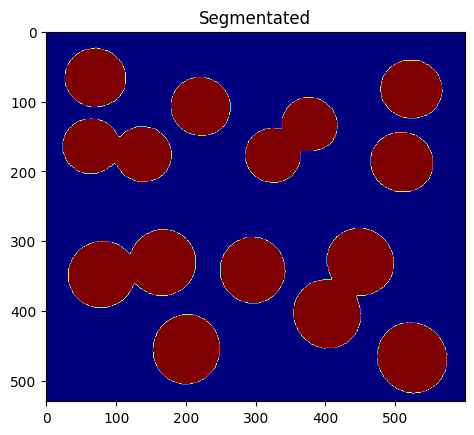

In [110]:
# Apply thresholding
thresh = segmentate(img_H, T, 255, invert=True)

# plot
plt.clf()
plt.imshow(thresh, cmap='jet')
plt.title('Segmentated')
plt.show()

Text(0.5, 1.0, 'Sure background')

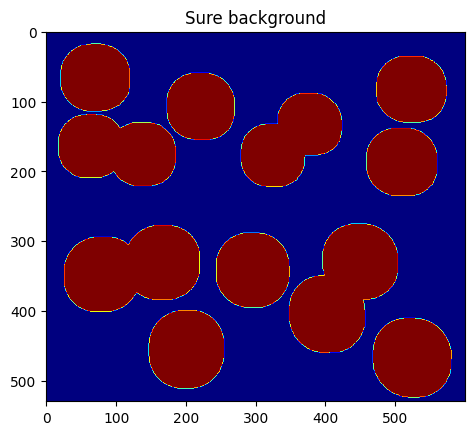

In [111]:
# Perform morphological operations
kernel = np.ones((5, 5), np.uint8)

# Closing
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# Remove small white regions
sure_bg = cv2.dilate(closing, kernel, iterations=3)

# plot
plt.imshow(sure_bg, cmap='jet')
plt.title('Sure background')

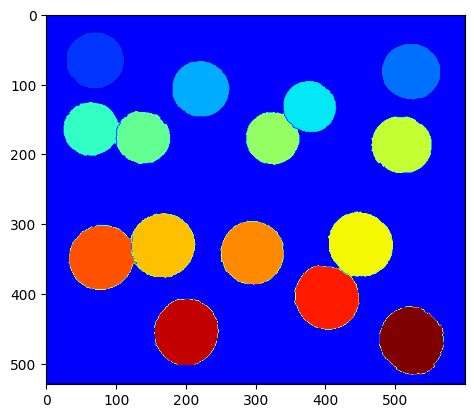

In [112]:
# Distance transform and normalization
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Subtract the sure foreground from the sure background
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labelling
_, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers + 1

# Now, mark the region of unknown with zero
markers[unknown == 255] = 0


# Apply watershed
markers = cv2.watershed(img, markers)

# Boundaries
whatershed_boundaries = np.zeros_like(img)
whatershed_boundaries[markers == -1] = [255, 0, 0]
# dilate boundaries for better visibility
kernel = np.ones((3, 3), np.uint8)
whatershed_boundaries = cv2.dilate(whatershed_boundaries, kernel)

# plot
plt.imshow(markers, cmap='jet')

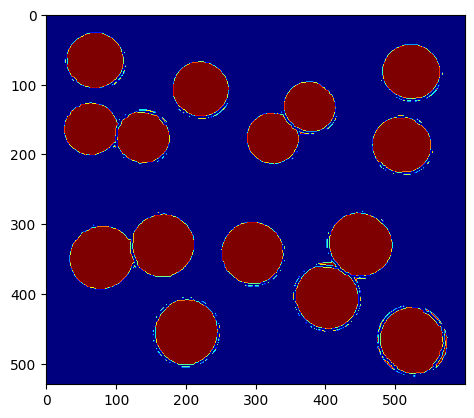

In [113]:
# odstraneni okraju minci z binarniho obrazu pomoci odecteni okraju z rozvodi
bin_img_without_boundaries = np.copy(thresh)
bin_img_without_boundaries[whatershed_boundaries[:, :, 0] == 255] = 0

# plot
plt.imshow(bin_img_without_boundaries, cmap='jet')

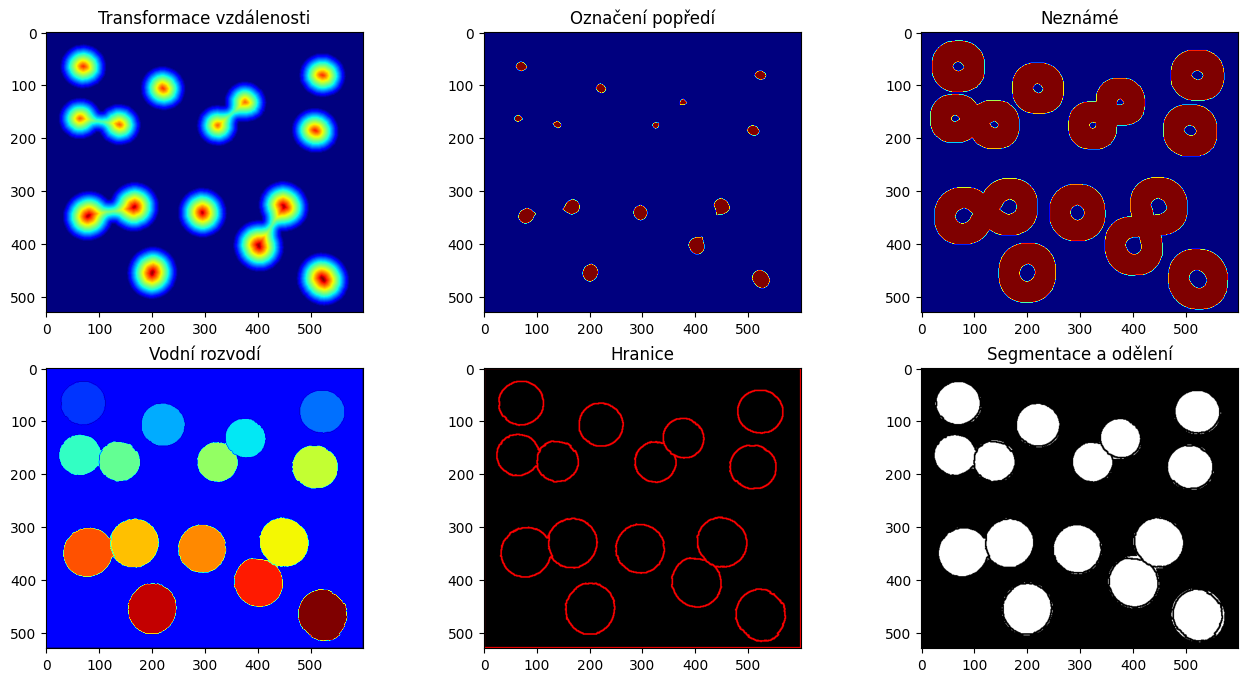

Done


In [114]:
# Display the result

plot_imgs(
    [dist_transform, sure_fg, unknown, markers, whatershed_boundaries, bin_img_without_boundaries],
    ["Transformace vzdálenosti", "Označení popředí", "Neznámé", "Vodní rozvodí", "Hranice", "Segmentace a odělení"],
    cmaps=["jet", "jet", "jet", "jet", None, "gray"],
    rows=2,
    figsize=(16, 8)
)

print(Green + "Done" + NC)

3) Artefakty z oddělení objektů odsraňte při využítí algoritmu barvení oblastí. 
Např.: všechny objekty, které mají méně než 1000 obrazových bodů budou 
odstraněny. 

Numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220

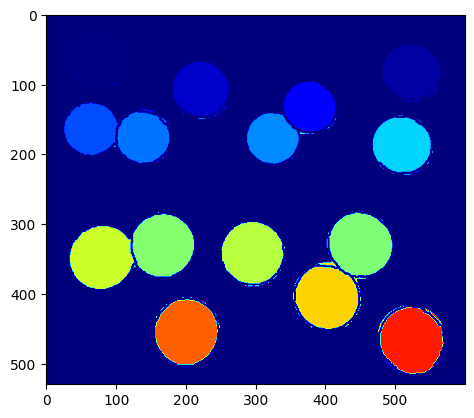

In [115]:
# reload lib functional
import importlib
from my_libs.img.functional import *
importlib.reload(ml.img.functional)


img_for_coloring = bin_img_without_boundaries

# invert image
img_for_coloring = cv2.bitwise_not(img_for_coloring)

# Colored objects:
img_colored, numbers = color_objects(img_for_coloring)
print("Numbers:", numbers)
plt.figure("Colored objects")
plt.imshow(img_colored, cmap='jet')

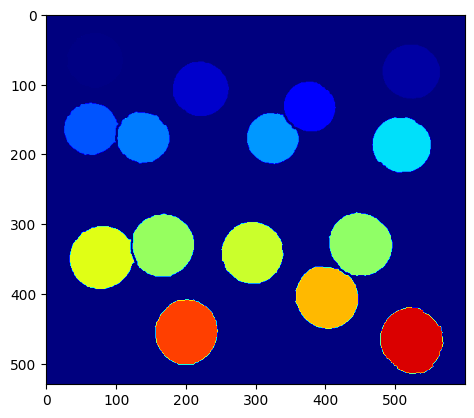

In [116]:
area = 1000

def remove_object_smaller_then(img, area):
    """
    Remove objects smaller then area
    """
    # find contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # remove small objects
    for contour in contours:
        if cv2.contourArea(contour) < area:
            cv2.drawContours(img, [contour], -1, 0, -1)
    return img

# remove small objects
img_filtered = remove_object_smaller_then(img_colored, area)

# plot
plt.figure("Filtered")
plt.imshow(img_filtered, cmap='jet')

4)  Z  binárního  obrazu  vytvořte  granulometrické  spektrum.  Spektrum 
analyzujte  (např.  od  objektů  velikosti  40x40  obrazových  bodů).  Všechny 
poměry menší než 0,9 zanedbejte. Zaokrouhlení poměru - bez desetiné části.  

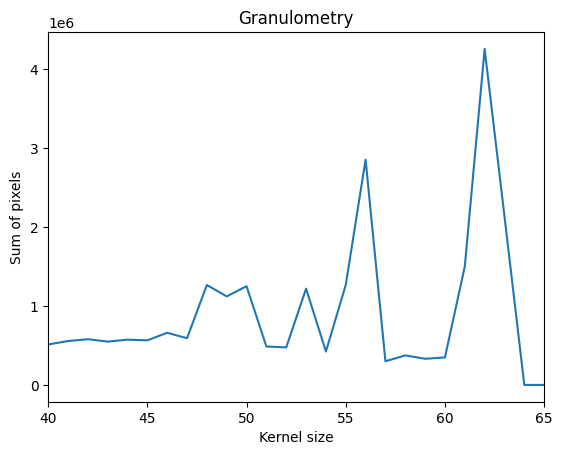

In [ ]:

# granulometry
# přesunuta do functional.py
 
# granulometry
# binary image 0/255
binary_img = np.zeros_like(img_filtered)
binary_img[img_filtered > 0] = 1
granulometry_values = granulometry(binary_img)

# plot
plt.plot(granulometry_values)
plt.title('Granulometry')
plt.xlabel('Kernel size')
plt.ylabel('Sum of pixels')
plt.xlim(40, 65)
plt.show()

In [118]:
valid = {
    "number_of_objects": 15,
    "objects" : [
        {
            "size" : 46,
            "number" : 1
        }, {
            "size" : 47,
            "number" : 1
        }, {
            "size" : 48,
            "number" : 1
        }, {
            "size" : 51,
            "number" : 1
        }, {
            "size" : 53,
            "number" : 1
        }, {
            "size" : 54,
            "number" : 3
        }, {
            "size" : 59,
            "number" : 1
        }, {
            "size" : 60,
            "number" : 4
        }, {
            "size" : 61,
            "number" : 2
        }
    ]
}

5)  Výstupem bude velikost objektu a počet objektů. 

No. objects: 1   size: 48 x 48
No. objects: 1   size: 49 x 49
No. objects: 1   size: 50 x 50
No. objects: 1   size: 53 x 53
No. objects: 1   size: 55 x 55
No. objects: 3   size: 56 x 56
No. objects: 1   size: 61 x 61
No. objects: 4   size: 62 x 62
No. objects: 2   size: 63 x 63
Sum of objects: 15


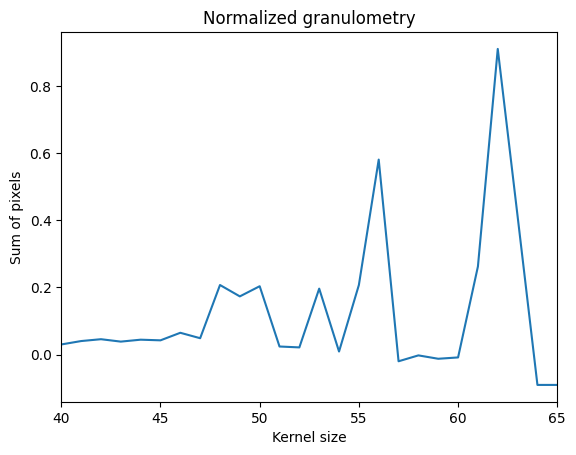

In [119]:
#No. objects: 1 size: 46 x 46

def normalize_vector(vector):
    """
    Normalize vector
    """
    return (vector - np.min(vector)) / (np.max(vector) - np.min(vector))

base = 0.21
normalized = normalize_vector(granulometry_values) -0.09

# No. objects: 1 size: 46 x 46
sum_of_objects = 0
for i in range(len(normalized)):
    if normalized[i] > base/2:
        number_of_objects = normalized[i]/base
        #print(number_of_objects)
        # zaokrouhleni
        number_of_objects = np.round(number_of_objects)
        sum_of_objects += number_of_objects
        print(f"No. objects: {number_of_objects:.0f}   size: {i} x {i}")

print(f"Sum of objects: {sum_of_objects:.0f}")

# plot
plt.plot(normalized)
plt.title('Normalized granulometry')
plt.xlabel('Kernel size')
plt.ylabel('Sum of pixels')
plt.xlim(40, 65)
plt.show()



68.2323463198752
66.88810866432257
65.05235648448462
67.1253502400173
63.17003102551775
64.42904168423517
65.09935595254565
59.3724556638769
52.54885256728096
53.77869356073139
55.23990659116553
52.2125948946174
56.80166784080556
58.24960427678398
57.63255283539805


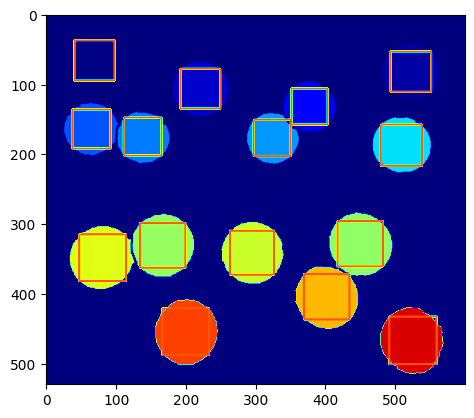

In [ ]:
contours, _ = cv2.findContours(img_filtered, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_filtered_copy = img_filtered

for i, contour in enumerate(contours):
    [x, y], radius = cv2.minEnclosingCircle(contour)
    square_size = 2 * radius / np.sqrt(2)
    top_left = (int(centers[i][0] - square_size/2), int(centers[i][1] + square_size/2))
    bottom_right = (int(centers[i][0] + square_size/2), int(centers[i][1] - square_size/2))
    cv2.rectangle(img_filtered_copy, top_left, bottom_right, [200, 0, 200], 2)





#cv2.drawContours(img_filtered, contours, -1, [255, 0, 255], 10)


plt.imshow(img_filtered_copy, cmap="jet")

In [ ]:
# Doesn't work because of different order of items from minEnclosingCircle() and the "valid" dictionary
""" centers = []
for i, contour in enumerate(contours):
    [x, y], radius = cv2.minEnclosingCircle(contour)
    centers.append([x, y])

i = 0
for obj in valid["objects"]:
    square_size = obj["size"]

    for nmr in range(obj["number"]):
        top_left = (int(centers[i][0] - square_size/2), int(centers[i][1] + square_size/2))
        bottom_right = (int(centers[i][0] + square_size/2), int(centers[i][1] - square_size/2))
        print(square_size)
        cv2.rectangle(img_filtered_copy, top_left, bottom_right, [200, 0, 200], 2)
        i += 1 """

46
47
48
51
53
54
54
54
59
60
60
60
60
61
61
